In [1]:
import sys
sys.path.append('../env/lib/python3.11/site-packages')
sys.path.append('..')
sys.path

['/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '../env/lib/python3.11/site-packages',
 '..']

In [2]:
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from project_euromir import equilibrate
from project_euromir.loss_no_hsde import (_densify)

# %matplotlib tk

LOADING LIBRARY /home/enzo/repos/project_euromir/experiments/../project_euromir/libproject_euromir.so


In [168]:
MASTER_SEED = 120
np.random.seed(MASTER_SEED)

m, n = 81, 70
x = cp.Variable(n)
A = np.random.randn(m, n)
b = np.random.randn(m)
objective = cp.norm1(A @ x - b)
d = np.random.randn(n, 5)
constraints = [cp.abs(x) <= .75, x @ d == 2.,]
program = cp.Problem(cp.Minimize(objective), constraints)

data = program.get_problem_data('SCS')[0]
matrix=data['A']
b=data['b']
c=data['c']
zero=data['dims'].zero
nonneg=data['dims'].nonneg
m = len(b)
n = len(c)

QR = False
if not QR:
    d, e, sigma, rho, matrix_transf, b_transf, c_transf = \
            equilibrate.hsde_ruiz_equilibration(
                    matrix, b, c, dimensions={
                        'zero': zero, 'nonneg': nonneg, 'second_order': ()},
                    max_iters=1000)
else:
    q, r = np.linalg.qr(np.vstack([matrix.todense(), c.reshape((1, n))]))
    matrix_transf = q[:-1].A
    c_transf = q[-1].A1
    sigma = np.linalg.norm(b) / np.mean(np.linalg.norm(matrix_transf, axis=1))
    b_transf = b/sigma


workspace = {
    'SCALE_GAP': 1,
    'SCALE_Y_ERROR':1,
    'SCALE_S_ERROR':1
}



# variable is xy
def loss_gradient(xy, m, n, zero, matrix, b, c, workspace):
    """Function for LBFGS loop, used in line search as well."""
    
    # preallocate some variables
    s_error = np.empty(m, dtype=float)
    gradient = np.empty(n+m, dtype=float)

    x = xy[:n]
    y = xy[n:]

    # zero cone dual variable is unconstrained
    y_error = np.minimum(y[zero:], 0.)
    
    y_error *= workspace['SCALE_Y_ERROR']

    # this must be all zeros
    dual_residual = matrix.T @ y + c

    # slacks
    s = -matrix @ x + b

    # slacks for zero cone must be zero
    s_error[:zero] = s[:zero]
    s_error[zero:] = np.minimum(s[zero:], 0.)
    
    s_error *= workspace['SCALE_S_ERROR']

    # duality gap
    gap = (c.T @ x + b.T @ y) * workspace['SCALE_GAP']

    # loss
    loss = np.linalg.norm(y_error)**2
    loss += np.linalg.norm(dual_residual)**2
    loss += np.linalg.norm(s_error)**2
    loss += gap**2

    # dual residual sqnorm
    gradient[n:] = 2 * (matrix @ dual_residual)

    # s_error sqnorm
    gradient[:n] = -2 * (matrix.T @ s_error) * workspace['SCALE_S_ERROR']

    # y_error sqnorm
    gradient[n+zero:] += 2 * y_error * workspace['SCALE_Y_ERROR']

    # gap sq
    gradient[:n] += (2 * gap) * c * workspace['SCALE_GAP']
    gradient[n:] += (2 * gap) * b * workspace['SCALE_GAP']

    return loss, gradient


# these functions should be unpacked inside newton-cg
def separated_loss(xy):
    return loss_gradient(
        xy, m=m, n=n, zero=zero, matrix=matrix_transf, b=b_transf, c=c_transf, workspace=workspace)[0]

def separated_grad(xy):
    return np.copy(loss_gradient(
        xy, m=m, n=n, zero=zero, matrix=matrix_transf, b=b_transf, c=c_transf, workspace=workspace)[1])

    
def hessian(xy, m, n, zero, matrix, b, c, workspace, regularizer = 0.):
    """Hessian to use inside LBFGS loop."""

    x = xy[:n]
    y = xy[n:]

    # zero cone dual variable is unconstrained
    y_error = np.minimum(y[zero:], 0.)

    # this must be all zeros
    dual_residual = matrix.T @ y + c

    # slacks
    s = -matrix @ x + b

    # slacks for zero cone must be zero
    s_error = np.empty_like(s)
    s_error[:zero] = s[:zero]
    s_error[zero:] = np.minimum(s[zero:], 0.)

    def _matvec(dxdy):
        result = np.empty_like(dxdy)
        dx = dxdy[:n]
        dy = dxdy[n:]

        # dual residual sqnorm
        result[n:] = 2 * (matrix @ (matrix.T @ dy))

        # s_error sqnorm
        s_mask = np.ones(m, dtype=float)
        s_mask[zero:] = s_error[zero:] < 0.
        result[:n] = 2 * (matrix.T @ (s_mask * (matrix @ dx))) * workspace['SCALE_S_ERROR']**2

        # y_error sqnorm
        y_mask = np.ones(m-zero, dtype=float)
        y_mask[:] = y_error < 0.
        result[n+zero:] += 2 * y_mask * dy[zero:] * workspace['SCALE_Y_ERROR']**2

        # gap
        constants = np.concatenate([c, b])
        result[:] += constants * (2 * (constants @ dxdy)) * workspace['SCALE_GAP']**2

        return result + regularizer * dxdy

    return sp.sparse.linalg.LinearOperator(
        shape=(len(xy), len(xy)),
        matvec=_matvec
    )    
    
    
    
def separated_hessian(xy):
    return hessian(
        xy, m=m, n=n, zero=zero, matrix=matrix_transf, b=b_transf, c=c_transf,
        workspace=workspace, regularizer=0.)

def dense_hessian(xy):
    return _densify(hessian(
        xy, m=m, n=n, zero=zero, matrix=matrix_transf, b=b_transf, c=c_transf,
        workspace=workspace, regularizer=0.))#1e-10))

In [77]:
workspace['SCALE_GAP'] = 1
workspace['SCALE_Y_ERROR'] = 1
workspace['SCALE_S_ERROR'] = 1


print('\nCHECKING GRADIENT')
for i in range(10):
    print(sp.optimize.check_grad(separated_loss, separated_grad, np.random.randn(n+m)))#, epsilon=1e-8))
    
print('\nCHECKING HESSIAN')
for i in range(10):
    print(sp.optimize.check_grad(separated_grad, dense_hessian, np.random.randn(n+m)))


CHECKING GRADIENT
1.1724365045916606e-05
1.4708677824213562e-05
1.356375594335425e-05
1.3029475131428598e-05
1.2998648437408286e-05
1.4532331228614665e-05
1.1140564338501662e-05
1.5727084315158747e-05
1.8864156580795226e-05
1.709211564807148e-05

CHECKING HESSIAN
2.8590053261115433e-06
3.132560438339349e-06
3.7776133379945417e-06
2.8287560745035742e-06
2.867783614950541e-06
2.4329890720593626e-06
3.6404848958377982e-06
2.196805546070164e-06
3.3536047656012005e-06
3.8459510121365754e-06


In [14]:
def line_search(xy, direction): # can be made much smarter, I understand enough dcsrch now
    current_loss = separated_loss(xy)
    for i in range(200):
        proposed = xy + direction * 0.5**i
        if separated_loss(proposed) < current_loss:
            break
    return proposed

CONVERGED IN ITERS 145
FINAL LOSS: 1.6975878157515966e-32


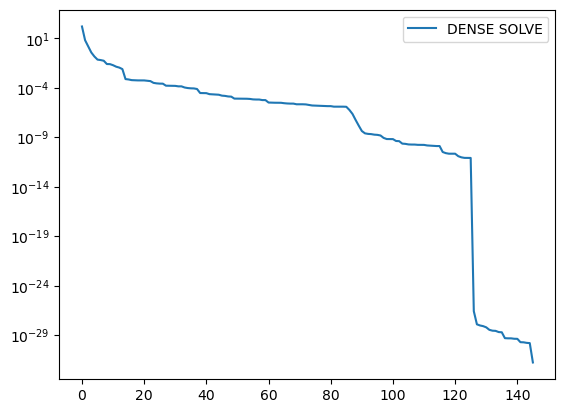

In [15]:
np.random.seed(0)
xy = np.random.randn(n+m)

losses = []

for i in range(350):
    # print(i)
    current_loss = separated_loss(xy)
    losses.append(current_loss)
    if current_loss < 1e-30:
        print('CONVERGED IN ITERS', i)
        break
    current_grad = separated_grad(xy)
    direction = np.linalg.lstsq(dense_hessian(xy), -current_grad, rcond=None)[0]
    xy = line_search(xy, direction)

plt.plot(np.arange(len(losses)), losses, label=f'DENSE SOLVE')
print('FINAL LOSS:', losses[-1])
plt.legend()
plt.yscale('log')
plt.show()
    # print('FINAL LOSS:', losses[-1])


### Bunch of experiments with 81x71, 2zero, .75 constraints 

- no scaling: 110 iters, 7.7e-31

#### upscaling gap

- scale gap = 2; 102 iters, 2e-32
- scale gap = 5; 95 iters, 2e-32
- scale gap = 10; 101 iters, 9e-31
- scale gap = 20; 76 iters, 8e-31
- scale gap = 50; 141 iters, 7e-31, ~90 1e-27
- scale gap = 100; 99 iters, ~60 1e-25
- scale gap = 200; ~100 1e-26

#### downscaling gap
doesn't seem to help
.1 154 iters



#### scale y
upscaling doesn't seem to help, quite clear it makes slower
downscaling also, seems slower anyway, sadly



#### scale s
upscaling makes slower, seems very sensitive?
scale 100, ~175 iters
scale .1, 168 iters
scale .01, 221 iters



#### scale y and s same
upscaling 10; 216 iters
downscale .1; 108 iters
downscale .01; 117 iters
downscale 0.001; gets stuck at 1e-14 loss;


#### upscale gap, downscale cones
10 gap, 0.1 cones = 118; 

## So, it seems only gap helps a bit



### Run many tests 

{'SCALE_GAP': 0.01, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 249
{'SCALE_GAP': 0.010974987654930561, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 195
{'SCALE_GAP': 0.012045035402587823, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 235
{'SCALE_GAP': 0.013219411484660288, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 175
{'SCALE_GAP': 0.014508287784959394, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 248
{'SCALE_GAP': 0.015922827933410922, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 200
{'SCALE_GAP': 0.01747528400007684, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 222
{'SCALE_GAP': 0.019179102616724886, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 154
{'SCALE_GAP': 0.02104904144512021, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 194
{'SCALE_GAP': 0.023101297000831605, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 189
{'SCALE_GAP': 0.025353644939701114, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 233
{'SCALE_GAP': 0.027825594022071243, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR':

iters 65
{'SCALE_GAP': 100.0, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 1}
iters 75


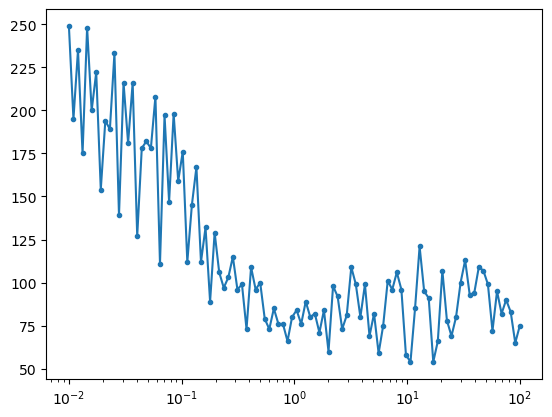

In [16]:
def get_convergence_iters():
    print(workspace)
    np.random.seed(0)
    xy = np.random.randn(n+m)
    losses = []
    for i in range(350):
        # print(i)
        current_loss = separated_loss(xy)
        losses.append(current_loss)
        if current_loss < 1e-25:
            print('iters', i)
            break
        current_grad = separated_grad(xy)
        direction = np.linalg.lstsq(dense_hessian(xy), -current_grad, rcond=None)[0]
        xy = line_search(xy, direction)

    return i

niters_at_gap = []
gaps = np.logspace(-2, 2, 100)
for gap in gaps:
    workspace['SCALE_GAP'] = gap
    niters_at_gap.append(get_convergence_iters())
    
plt.plot(gaps, niters_at_gap, '.-')
plt.xscale('log')

{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.01, 'SCALE_S_ERROR': 1}
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.010974987654930561, 'SCALE_S_ERROR': 1}
iters 146
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.012045035402587823, 'SCALE_S_ERROR': 1}
iters 173
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.013219411484660288, 'SCALE_S_ERROR': 1}
iters 164
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.014508287784959394, 'SCALE_S_ERROR': 1}
iters 128
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.015922827933410922, 'SCALE_S_ERROR': 1}
iters 191
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.01747528400007684, 'SCALE_S_ERROR': 1}
iters 90
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.019179102616724886, 'SCALE_S_ERROR': 1}
iters 150
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.02104904144512021, 'SCALE_S_ERROR': 1}
iters 134
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.023101297000831605, 'SCALE_S_ERROR': 1}
iters 182
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.025353644939701114, 'SCALE_S_ERROR': 1}
iters 212
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 0.027825594022071243, 'SCALE_S_ERROR': 1}
iters 1

iters 166
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 100.0, 'SCALE_S_ERROR': 1}
iters 179


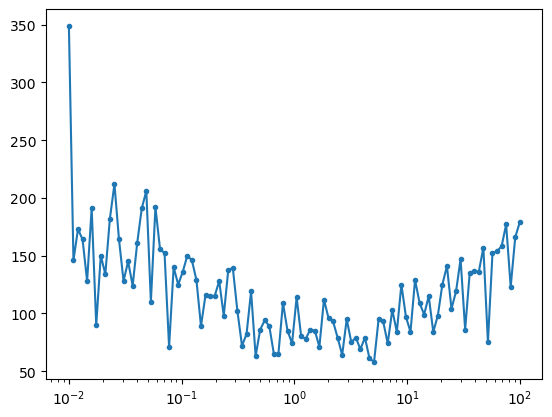

In [78]:
workspace['SCALE_GAP'] = 1
workspace['SCALE_Y_ERROR'] = 1
workspace['SCALE_S_ERROR'] = 1


niters = []
tests = np.logspace(-2, 2, 100)
for test in tests:
    workspace['SCALE_Y_ERROR'] = test
    niters.append(get_convergence_iters())
    
plt.plot(tests, niters, '.-')
plt.xscale('log')

{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.01}
iters 142
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.010974987654930561}
iters 103
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.012045035402587823}
iters 121
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.013219411484660288}
iters 157
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.014508287784959394}
iters 111
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.015922827933410922}
iters 87
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.01747528400007684}
iters 109
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.019179102616724886}
iters 84
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.02104904144512021}
iters 77
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.023101297000831605}
iters 88
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.025353644939701114}
iters 139
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 0.027825594022071243}


iters 177
{'SCALE_GAP': 1, 'SCALE_Y_ERROR': 1, 'SCALE_S_ERROR': 100.0}


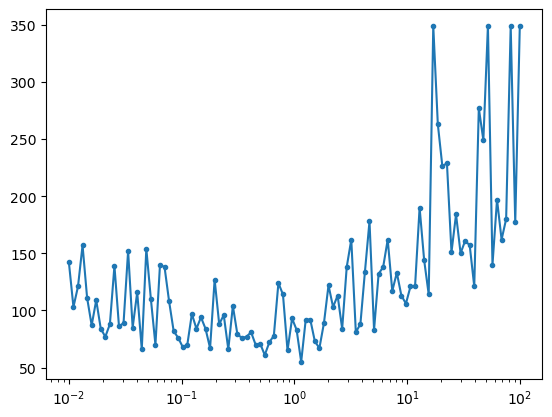

In [79]:
workspace['SCALE_GAP'] = 1
workspace['SCALE_Y_ERROR'] = 1
workspace['SCALE_S_ERROR'] = 1


niters = []
tests = np.logspace(-2, 2, 100)
for test in tests:
    workspace['SCALE_S_ERROR'] = test
    niters.append(get_convergence_iters())
    
plt.plot(tests, niters, '.-')
plt.xscale('log')

# PLAYING WITH SCALING FOR CG 

In [87]:
workspace['SCALE_GAP'] = 1
workspace['SCALE_Y_ERROR'] = 1
workspace['SCALE_S_ERROR'] = 1

program.solve(# verbose=True,
              # ECOS/CVXOPT
              # solver='ECOS', abstol=1e-16, reltol=1e-16, feastol=1e-16,
              # CLARABEL
              solver='CLARABEL', tol_feas = 1.0e-16, tol_gap_abs = 1.0e-16, tol_gap_rel=1e-16,
              # solver='GLPK', verbose=True, # CVXPY intf does not work?
              # SCS
              # solver = 'SCS', eps=1e-16, max_iters=1000000
             )#, eps=1e-16, max_iters=1000000)

np.max(constraints[0].violation())

3.3306690738754696e-16

In [88]:
xy = np.random.randn(m+n)
separated_loss(xy)

228.0845811666564

In [89]:
grad = separated_grad(xy)

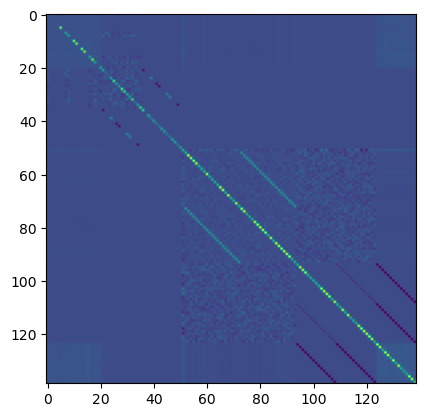

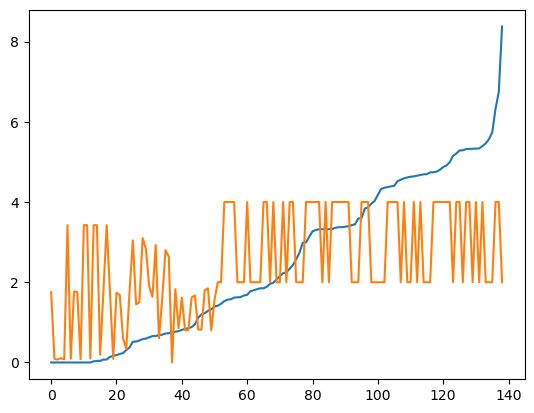

In [91]:
H = dense_hessian(xy)
plt.imshow(H)
plt.figure()
plt.plot(np.linalg.eigh(H)[0])
plt.plot(np.diag(H))

In [97]:
eival

array([-2.64534563e-15, -1.93715081e-15, -1.39773241e-15, -4.79652069e-16,
       -4.16299924e-16, -3.96463581e-16,  7.88985573e-17,  3.43543554e-16,
        4.58736699e-16,  5.04928738e-16,  1.07736215e-15,  1.46206343e-15,
        1.69839275e-15,  2.84310696e-02,  3.97224002e-02,  4.02273528e-02,
        7.21882298e-02,  7.34128179e-02,  1.40868621e-01,  1.62372830e-01,
        1.82807137e-01,  2.12717059e-01,  2.32433918e-01,  3.10323278e-01,
        3.74419197e-01,  5.17282258e-01,  5.22458399e-01,  5.47932742e-01,
        5.85599805e-01,  5.94376874e-01,  6.29116950e-01,  6.56254554e-01,
        6.58698411e-01,  6.83849254e-01,  6.92873292e-01,  7.21790030e-01,
        7.29226922e-01,  7.55590796e-01,  7.65366873e-01,  7.82809956e-01,
        8.11091454e-01,  8.39603380e-01,  8.55290554e-01,  8.81718452e-01,
        9.49245705e-01,  1.11404895e+00,  1.19992693e+00,  1.22815041e+00,
        1.28745015e+00,  1.32409224e+00,  1.39616133e+00,  1.41408402e+00,
        1.46323023e+00,  

# CG ITER SCALED 

iters 212
iters 181


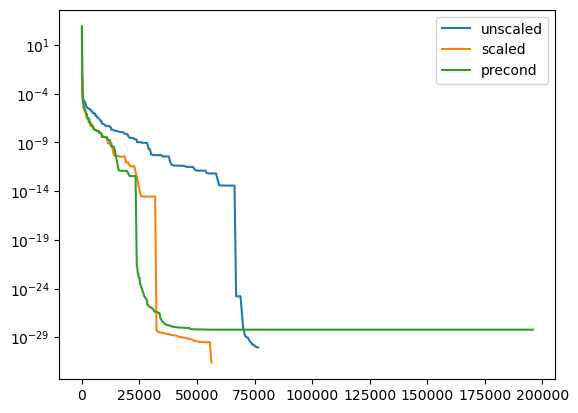

In [169]:
MINICOUNTER = 0

workspace['SCALE_GAP'] = 1
workspace['SCALE_Y_ERROR'] = 1
workspace['SCALE_S_ERROR'] = 1

def denser_count(dense):
    global MINICOUNTER
    MINICOUNTER = 0
    def matvec(x):
        global MINICOUNTER
        MINICOUNTER += 1
        return dense @ x
    return sp.sparse.linalg.LinearOperator(shape=dense.shape, matvec=matvec)


def get_scaler(H): # just to see how much we gain with perfect scaling
    # H sqrt
    eival, eivec = np.linalg.eigh(H)
    Hsqrt = np.diag(np.sqrt(np.maximum(eival, 0.))) @ eivec.T
    assert np.linalg.norm(Hsqrt.T @ Hsqrt - H) < 1e-12
    column_norms = np.linalg.norm(Hsqrt, axis=0)
    scaler = np.minimum(1 / column_norms, 10)
    return scaler

def cg_iter_scaled(H, grad, **kwargs):
    scaler = get_scaler(H)
    H_scaled = np.diag(scaler) @ H @ np.diag(scaler)
    grad_scaled = np.diag(scaler) @ grad
    result = sp.sparse.linalg.cg(denser_count(H_scaled), -grad_scaled, **kwargs)[0]
    return result * scaler


def cg_iter_scaled_precond(H, grad, **kwargs):
    scaler = get_scaler(H)
    result = sp.sparse.linalg.cg(denser_count(H), -grad, M = np.diag(scaler**2), **kwargs)[0]
    return result



def cg_iter_unscaled(H, grad, **kwargs):
    result = sp.sparse.linalg.cg(denser_count(H), -grad, **kwargs)[0]
    return result


np.random.seed(0)
xy = np.random.randn(n+m)

# kwargs = {'rtol':0., 'maxiter':20}
LEN = 500
CONVERGENCE = 1e-30
losses = [separated_loss(xy)]
used_iters = [0] 
for i in range(LEN):
    g = separated_grad(xy)
    direction = cg_iter_unscaled(dense_hessian(xy), g, rtol=min(0.5, np.linalg.norm(g)**.5))
    xy = line_search(xy, direction)
    current_loss = separated_loss(xy)
    losses.append(current_loss)
    used_iters.append(used_iters[-1] + MINICOUNTER)

    if current_loss < CONVERGENCE:
        print('iters', i)
        break

plt.plot(used_iters, losses, label='unscaled')

##
## SCALED
##

np.random.seed(0)
xy = np.random.randn(n+m)

losses = [separated_loss(xy)]
used_iters = [0] 

for i in range(LEN):
    
    g = separated_grad(xy)
    direction = cg_iter_scaled(dense_hessian(xy), g, rtol=min(0.5, np.linalg.norm(g)**.5))
    xy = line_search(xy, direction)
    current_loss = separated_loss(xy)
    losses.append(current_loss)
    used_iters.append(used_iters[-1] + MINICOUNTER)

    if current_loss < CONVERGENCE:
        print('iters', i)
        break

plt.plot(used_iters, losses, label='scaled')


##
## SCIPY CG PRECOND
##

np.random.seed(0)
xy = np.random.randn(n+m)

losses = [separated_loss(xy)]
used_iters = [0] 

for i in range(LEN):
    
    g = separated_grad(xy)
    direction = cg_iter_scaled_precond(dense_hessian(xy), g, rtol=min(0.5, np.linalg.norm(g)**.5))
    xy = line_search(xy, direction)
    current_loss = separated_loss(xy)
    losses.append(current_loss)
    used_iters.append(used_iters[-1] + MINICOUNTER)

    if current_loss < CONVERGENCE:
        print('iters', i)
        break

plt.plot(used_iters, losses, label='precond')


plt.legend()
plt.yscale('log')

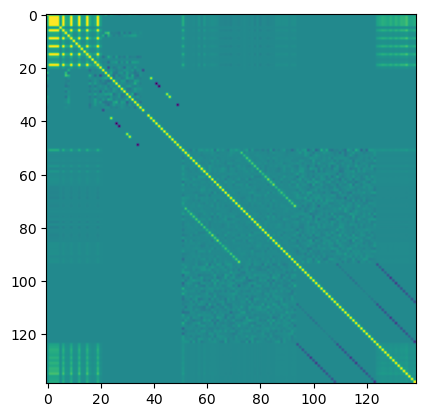

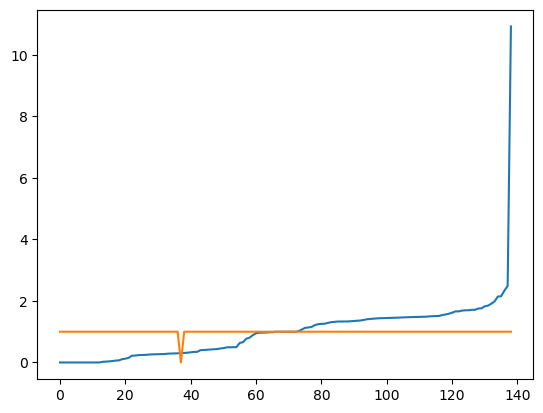

In [110]:
# H sqrt
eival, eivec = np.linalg.eigh(H)
Hsqrt = np.diag(np.sqrt(np.maximum(eival, 0.))) @ eivec.T

assert np.linalg.norm(Hsqrt.T @ Hsqrt - H) < 1e-12

column_norms = np.linalg.norm(Hsqrt, axis=0)
scaler = np.minimum(1 / column_norms, 10)

H_scaled = np.diag(scaler) @ H @ np.diag(scaler)


plt.imshow(H_scaled)
plt.figure()
plt.plot(np.linalg.eigh(H_scaled)[0])
plt.plot(np.diag(H_scaled))


In [112]:
np.diag(H_scaled)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [120]:
np.linalg.norm(grad_scaled)**.5

5.018999362014234

In [125]:
grad = separated_grad(xy)
grad_scaled = np.diag(scaler) @ grad

sp.sparse.linalg.cg(H_scaled, -grad_scaled, rtol=1e-4, maxiter=30)

(array([ 1.60933555e-01, -3.68086261e-01, -3.68086261e-01, -3.68086261e-01,
        -3.68086261e-01,  3.87528268e+00, -3.68086261e-01,  7.18100118e-01,
        -1.51524365e-01, -3.68086261e-01,  5.06885322e+00,  1.05350006e+00,
        -3.68086261e-01,  8.63836453e-01,  2.62153354e+00, -3.68086261e-01,
        -1.72881486e-01,  1.79673816e+00, -2.73485553e-01, -3.68086261e-01,
        -2.31446531e-01, -7.49199411e-01, -4.50359006e-01,  7.44705065e-02,
         1.29792804e+00,  1.50500383e-01, -2.86747834e-01,  1.62356509e-02,
         2.02944684e-01, -7.69043584e-01,  1.74021853e+00,  1.19984877e+00,
         1.89401545e-01,  8.79076871e-01, -1.70585171e+00, -7.75193709e-01,
        -3.47082633e-03,  0.00000000e+00, -2.31602212e+00,  6.33687383e-01,
         2.80039554e+00, -2.26861295e-01,  1.01516409e+00,  6.59303977e-01,
         1.26476687e+00,  7.69412303e-02, -3.32599565e-01,  6.74294218e-01,
        -2.88958646e+00,  2.80098618e-01,  9.92488775e-01,  3.09916668e+00,
        -6.7

In [127]:
sp.sparse.linalg.cg(H, -grad, rtol=1e-4, maxiter=30)

(array([ 1.21817136e-02, -9.06710153e-01, -8.06204948e-01, -9.76043741e-01,
        -8.34277921e-01,  2.09440783e+00, -9.02546860e-01,  5.16186435e-01,
        -1.37450678e-01, -8.48458593e-01,  2.73990657e+00,  5.68955111e-01,
        -9.48147216e-01,  4.66545650e-01,  1.41682317e+00, -1.30904385e+00,
        -1.81280154e-01,  9.70940241e-01, -2.95159870e-01, -8.95261025e-01,
        -1.83930146e-01, -5.73847826e-01, -4.53085677e-01,  1.26898900e-02,
         9.31239230e-01,  8.75530068e-02, -3.42115087e-02, -3.54067380e-01,
         1.15699711e-01, -4.55362334e-01,  1.40551335e+00,  1.08938766e+00,
         1.09140069e-01,  1.12240400e+00, -1.35550892e+00, -4.65588918e-01,
        -1.49162266e-03,  0.00000000e+00, -1.71327624e+00,  7.35651695e-01,
         2.20065700e+00, -3.67829624e-03,  6.82462741e-01,  5.17307177e-01,
         9.78046585e-01, -8.63137668e-02, -5.52037379e-01,  5.02614821e-01,
        -2.12595284e+00,  3.03528973e-01,  7.93343821e-01,  2.18830023e+00,
        -4.4

### USING LSQR INSTEAD 

1795.9773188345885
29.31652539415214


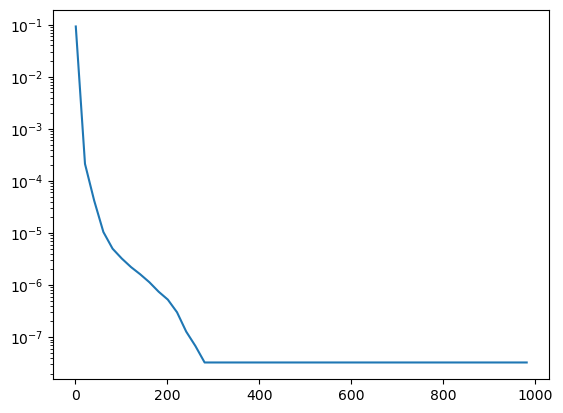

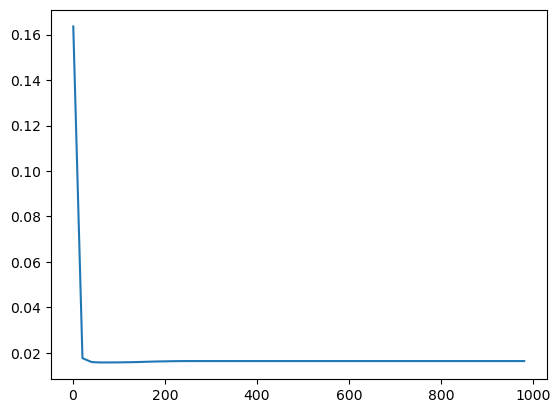

In [8]:
def residual(xy):
    x, y = xy[:n], xy[n:]
    
    y_error = np.minimum(y[zero:], 0.)

    dual_residual = matrix_transf.T @ y + c_transf

    s = -matrix_transf @ x + b_transf
    
    s[zero:] = np.minimum(s[zero:], 0.)

    gap = c_transf.T @ x + b_transf.T @ y

    return np.concatenate([y_error, dual_residual, s, [gap]])

def Dresidual(xy):
    
    x, y = xy[:n], xy[n:]
    
    y_active = np.zeros(m, dtype=float)
    y_active[zero:] = y[zero:]<=0
    
    s = -matrix_transf @ x + b_transf
    
    s_active = np.ones(m, dtype=float)
    s_active[zero:] = s[zero:]<=0
    
    return sp.sparse.bmat([
        [None, sp.sparse.diags(y_active).tocsc()[zero:]],
        [None, matrix_transf.T],
        [- sp.sparse.diags(s_active) @ matrix_transf, None],
        [c_transf.reshape(1,n), b_transf.reshape(1,m)]
    ])
#     dual_residual = matrix_transf.T @ y + c_transf

#     s = -matrix_transf @ x + b_transf
    
#     s[zero:] = np.minimum(s[zero:], 0.)

#     gap = c_transf.T @ x + b_transf.T @ y


print(np.linalg.norm(residual(xy))**2,)

#plt.imshow(Dresidual(xy).todense()[:])
def get_best_loss_direction(xy, direction):
    return np.min([separated_loss(xy + step * direction) for step in steps])

def get_next_point(xy, direction):
    which = np.argmin([separated_loss(xy + step * direction) for step in steps])
    return xy + (steps[which]) * direction
steps = np.logspace(-10,0,100)

H = separated_hessian(xy)
grad = separated_grad(xy)
steps = np.logspace(-10,0,100)

EXPONENT = 0.25

TOL=1e-6
DAMP=0#1e-4
iters = np.arange(1,1000,20)
losses = []
residualnorms=[]
for iterlim in iters:
    direction = sp.sparse.linalg.lsmr(Dresidual(xy), -residual(xy), atol=TOL, btol=TOL, damp=DAMP,
                                      maxiter=iterlim)[0]
    #direction = sp.sparse.linalg.lsqr(Dresidual(xy), -residual(xy), atol=0., btol=0., iter_lim=iterlim)[0]
    losses.append(get_best_loss_direction(xy, direction))
    residualnorms.append(np.linalg.norm(H @ direction + grad))
    # if np.linalg.norm(H @ direction + grad) < (np.linalg.norm(grad)**(1+EXPONENT)):
        # break
        
    
plt.plot(iters[:len(losses)], 
         np.array(residualnorms)/(np.linalg.norm(grad)**(1+EXPONENT)), label=f'||r||*||g||^-({1+EXPONENT})')
plt.yscale('log')
plt.figure()
plt.plot(iters[:len(losses)],np.array(losses)/(np.linalg.norm(residual(xy))**2))

xy = get_next_point(xy, direction)
print(separated_loss(xy))

# Scaling of columns? 

(2271, 1398)


(array([147.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5., 149.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  39.,
          0.,   4., 471.,   0.,   0.,   0.,   0.,  15.,   0.,   0.,   0.,
          0., 142.,   0.,   0.,   0., 425.]),
 array([0.        , 0.02828491, 0.05656982, 0.08485473, 0.11313964,
        0.14142455, 0.16970946, 0.19799437, 0.22627928, 0.25456418,
        0.28284909, 0.311134  , 0.33941891, 0.36770382, 0.39598873,
        0.42427364, 0.45255855, 0.48084346, 0.50912837, 0.53741328,
        0.56569819, 0.5939831 , 0.62226801, 0.65055292, 0.67883783,
        0.70712274, 0.73540764, 0.76369255, 0.79197746, 0.82026237,
        0.84854728, 0.87683219, 0.9051171 , 0.93340201, 0.96168692,
        0.98997183, 1.01825674, 1.04654165, 1.07482656, 1.10311147,
        1.13139638, 1.15968129, 1.1879662 , 1.2162511 , 1.24453601,
        1.27282092, 1.30110583, 1.32939074, 1.

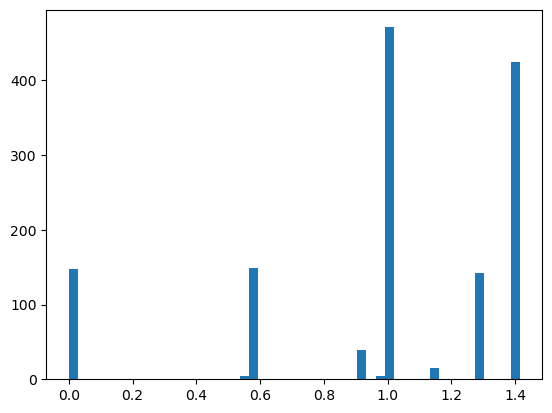

In [209]:
print(Dresidual(xy).shape)
plt.hist(np.linalg.norm(Dresidual(xy).todense(), axis=0), bins=50)

## MINI SOLVER 

In [579]:
np.linalg.norm(separated_grad(xy))

7.819071330021671e-16

In [715]:
np.random.seed(0)
xy = np.random.randn(n+m)
TOTITERS = 0

In [716]:
TOL=1e-2
DAMP=1e-4


for i in range(1,101):
    
#     global iter_used
#     iter_used = 0
     
#     D = Dresidual(xy)
#     def matvec(var):
#         global iter_used
#         iter_used += 1
#         return D @ var
#     def rmatvec(var):
#         global iter_used
#         iter_used += 1
#         return D.T @ var
#     wrapped = sp.sparse.linalg.LinearOperator(shape=D.shape,
#                                              matvec=matvec,
#                                              rmatvec=rmatvec,)
    
    TOL = 1e-12 #max(separated_loss(xy)**0.5, 1e-8)
    result = sp.sparse.linalg.lsmr(
        #wrapped, 
        Dresidual(xy),
        -residual(xy), 
        atol=0.,
        btol=TOL,#np.linalg.norm(separated_grad(xy))**.5, 
        damp=DAMP,#1e-3,
        maxiter=10000)
    # print('iters', result[2])
    #print('iters', iter_used)
    direction = result[0]
    xy = get_next_point(xy, direction)
    # xy += direction
    TOTITERS += result[2] #iter_used
    print('iters', TOTITERS, 'loss', separated_loss(xy))
    if separated_loss(xy) < 1e-25:
        break

iters 574 loss 27.83195265972278
iters 1312 loss 2.884542891256059
iters 1836 loss 0.6416850697554278
iters 3026 loss 0.3530810469418572
iters 3983 loss 0.2538035491703633
iters 4573 loss 0.14165754389851112
iters 5358 loss 0.08916730032290011
iters 6217 loss 0.08335596285313752
iters 7047 loss 0.0738648207906936
iters 7797 loss 0.03213948703751669
iters 8770 loss 0.028159432043503064
iters 9352 loss 0.010275255112950014
iters 10237 loss 0.00927747135369286
iters 11144 loss 0.006781680801958021
iters 11900 loss 0.004062769980356029
iters 12971 loss 0.003739825394414027
iters 13768 loss 0.0023586480261149766
iters 15169 loss 0.0023579293494375188
iters 16288 loss 0.0019166356548574444
iters 17294 loss 0.0017803944719270172
iters 18210 loss 0.0010421196530086732
iters 19616 loss 0.0010312547814803035
iters 21231 loss 0.0010309371610243117
iters 22861 loss 0.001030583195545363
iters 24431 loss 0.0010062432587785832
iters 25648 loss 0.0008681469097759874
iters 26644 loss 0.0007549318656194

# DEPENDENCE ON NUMBER OF CG ITERS 

In [13]:
np.random.seed(0)
xy = np.random.randn(n+m)

1.873018098622551e-06


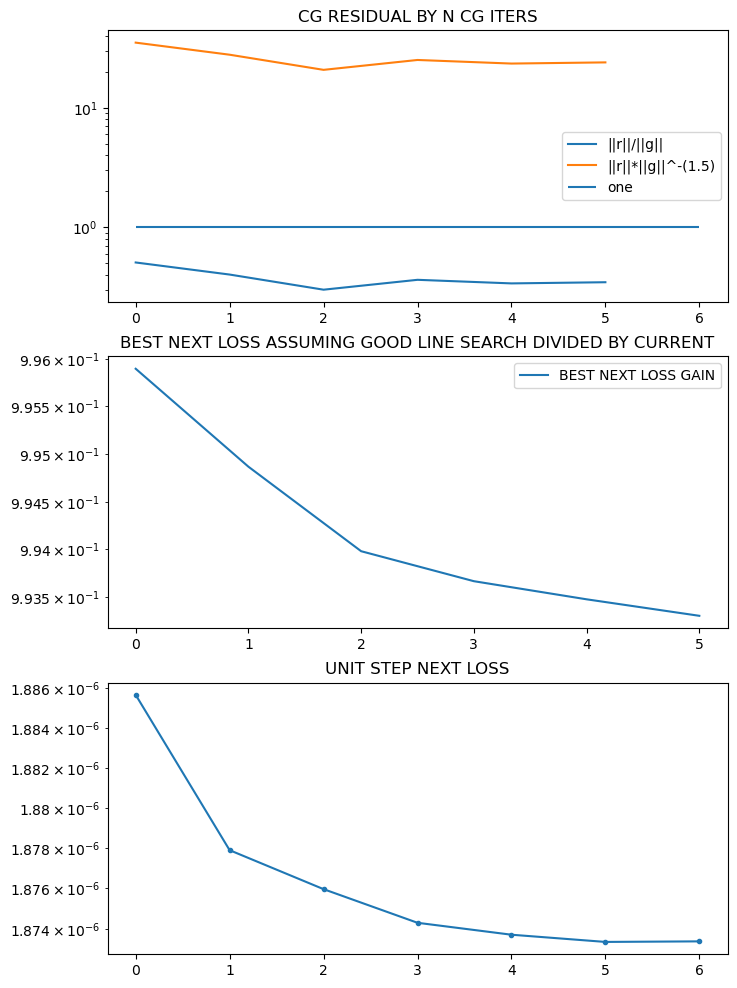

In [174]:

H = separated_hessian(xy)
grad = separated_grad(xy)
steps = np.logspace(-10,0,100)

residualnorms = []
# len_direction = []
best_losses = []
unit_step_losses = [separated_loss(xy)]
def get_best_loss_direction(xy, direction):
    return np.min([separated_loss(xy + step * direction) for step in steps])

def get_next_point(xy, direction):
    which = np.argmin([separated_loss(xy + step * direction) for step in steps])
    return xy + (steps[which]) * direction

EXPONENT = .5
FREQ_CHECK = 1

for i in range(1, 100):
    cg_solution = sp.sparse.linalg.cg(H, -grad, atol=0., rtol=0., maxiter=i)[0]
    residualnorms.append(np.linalg.norm(H @ cg_solution + grad))
    # len_direction.append(np.linalg.norm(cg_solution))
    
    best_losses.append(get_best_loss_direction(xy, cg_solution))
    if np.linalg.norm(H @ cg_solution + grad) < (np.linalg.norm(grad)**(1+EXPONENT)):
        pass
        #break
    unit_step_losses.append(separated_loss(xy + cg_solution))
    if (i % FREQ_CHECK == 0) and (unit_step_losses[-1] > unit_step_losses[-1 - FREQ_CHECK]):
        break
fig, axes = plt.subplots(3, figsize=(8,12))

plt.sca(axes[0])
plt.plot(np.array(residualnorms)/np.linalg.norm(grad), label='||r||/||g||')
plt.plot(np.array(residualnorms)/(np.linalg.norm(grad)**(1+EXPONENT)), label=f'||r||*||g||^-({1+EXPONENT})')
# plt.plot(np.array(residualnorms)/(np.linalg.norm(grad)**1.3), label='||r||*||g||^-1.3')
# plt.plot(np.array(residualnorms)/(np.linalg.norm(grad)**1.5), label='||r||*||g||^-1.5')
plt.hlines(1, xmin=0, xmax=len(residualnorms), label='one')
plt.yscale('log')
plt.legend()
plt.title('CG RESIDUAL BY N CG ITERS')

# plt.figure()
# plt.plot(np.array(len_direction) / np.linalg.norm(grad))
# plt.title('LENGHT OF THE DIRECTION DIV BY GRAD LEN')

plt.sca(axes[1])
plt.plot((best_losses) / separated_loss(xy), label='BEST NEXT LOSS GAIN')
plt.yscale('log')
plt.legend()
plt.title("BEST NEXT LOSS ASSUMING GOOD LINE SEARCH DIVIDED BY CURRENT")

plt.sca(axes[2])
plt.plot(unit_step_losses, '.-')
plt.yscale('log')
plt.title("UNIT STEP NEXT LOSS")

xy = get_next_point(xy, cg_solution)
print(separated_loss(xy))

## Same code as above, without plots, iterated 

In [ ]:
np.random.seed(0)
xy = np.random.randn(n+m)
tot_losses = [separated_loss(xy)]
tot_matmuls = [0]

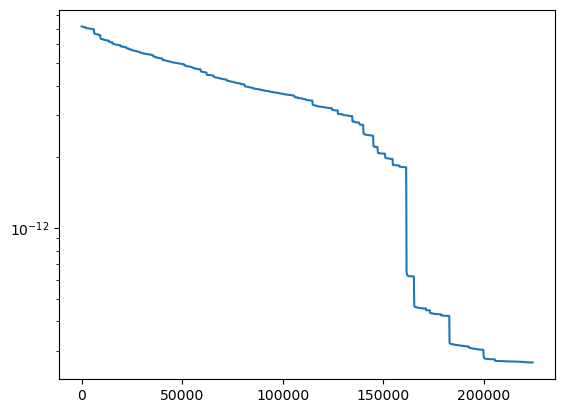

In [230]:
for k in range(2000):


    H = separated_hessian(xy)
    grad = separated_grad(xy)
    steps = np.logspace(-10,0,100)
    #residualnorms = []
    # len_direction = []
    #best_losses = []
    unit_step_losses = [separated_loss(xy)]
#     def get_best_loss_direction(xy, direction):
#         return np.min([separated_loss(xy + step * direction) for step in steps])

    def get_next_point(xy, direction):
        which = np.argmin([separated_loss(xy + step * direction) for step in steps])
        return xy + (steps[which]) * direction

    EXPONENT = .5
    FREQ_CHECK = 1

    for i in range(1, 100):
        cg_solution = sp.sparse.linalg.cg(H, -grad, atol=0., rtol=0., maxiter=i)[0]
        #residualnorms.append(np.linalg.norm(H @ cg_solution + grad))
        # len_direction.append(np.linalg.norm(cg_solution))

        #best_losses.append(get_best_loss_direction(xy, cg_solution))
        #if np.linalg.norm(H @ cg_solution + grad) < (np.linalg.norm(grad)**(1+EXPONENT)):
        #    pass
            #break
        unit_step_losses.append(separated_loss(xy + cg_solution))
        if (i % FREQ_CHECK == 0) and (unit_step_losses[-1] > unit_step_losses[-1 - FREQ_CHECK]):
            break
    #print('BROKE AT CGITER', i)
    xy = get_next_point(xy, cg_solution)
    # print(separated_loss(xy))
    tot_losses.append(separated_loss(xy))
    tot_matmuls.append(tot_matmuls[-1] + i)
    
plt.plot(tot_matmuls, tot_losses)
plt.yscale('log')

In [224]:
(np.log10(tot_losses[-1] / tot_losses[0]) / tot_matmuls[-1])

-3.2358056269255684e-06

# Line search research 

0.0004052682826740908 -4.066879161035486e-07 2.0408981730941382e-07
0.0005017514736412268


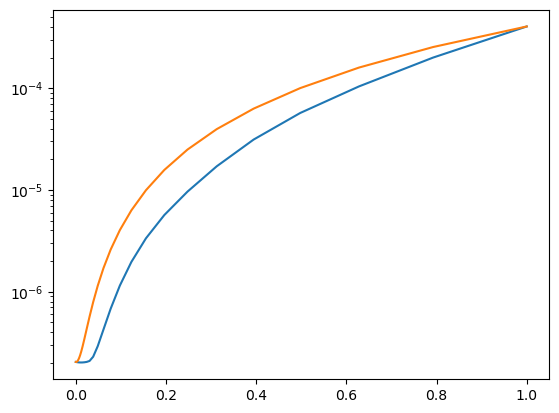

In [343]:
current_point = xy
current_loss = separated_loss(xy)
current_direction = cg_solution
current_gradient = separated_grad(xy)
assert current_direction @ current_gradient < 0

losses_on_line = [separated_loss(current_point + cg_solution * step) for step in steps]
plt.plot(steps, losses_on_line)

test_step_len = 1
loss_test_step = separated_loss(current_point + current_direction*test_step_len)

current_loss, loss_step_1

c = current_loss
b = current_direction @ current_gradient
# a * (1**2) + b * 1 + c = loss_step_1
def get_a(loss_at_step, step_len):
    return (loss_at_step - c - b * step_len)/(step_len**2)

a = get_a(loss_test_step, test_step_len)

vertex = -b / (2 * a)

print(a, b, c)
quad_approx = lambda x: a * x**2 + b * x + c
plt.plot(steps, [quad_approx(x) for x in steps])
plt.yscale('log')

print(vertex)

1.0 -7.527354584959345e-05
2.0408981730941382e-07 2.0167405033450724e-07


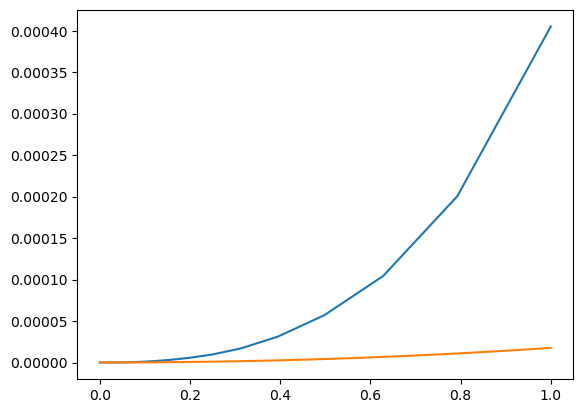

In [349]:
def fit_cubspline(x_left, loss_left, grad_left, x_right, loss_right, grad_right):
    # a * x^3 + b * x^2 + c * x + d
    assert grad_left < 0
    assert grad_right > 0
    assert x_left < x_right
    matrix = [
        [x_left**3, x_left**2, x_left, 1.],
        [x_right**3, x_right**2, x_right, 1.],
        [3 * x_left**2, 2 * x_left, 1., 0.],
        [3 * x_right**2, 2 * x_right, 1., 0.],
    ]
    rhs = [loss_left, loss_right, grad_left, grad_right]
    return np.linalg.solve(matrix, rhs)

current_point = xy
current_loss = separated_loss(xy)
current_direction = cg_solution
current_gradient = separated_grad(xy)


LEFT_STEP = 0
left_point = xy + current_direction * LEFT_STEP
left_loss = separated_loss(left_point)
left_grad = separated_grad(left_point)

RIGHT_STEP = 0.01187731700475939
right_point = xy + current_direction * RIGHT_STEP
right_loss = separated_loss(right_point)
right_grad = separated_grad(right_point)



a,b,c,d = fit_cubspline(x_left=LEFT_STEP, loss_left=left_loss, grad_left=current_direction@left_grad,
              x_right=RIGHT_STEP, loss_right=right_loss, grad_right=current_direction@right_grad)

my_spline = lambda x: a * x**3 + b * x**2 + c * x + d

xs = np.linspace(0,1)
plt.plot(steps, losses_on_line)
plt.plot(xs, [my_spline(x) for x in xs])
# plt.yscale('log')

print((current_direction@left_grad) / (current_direction@current_gradient),
      (current_direction@right_grad) / (current_direction@current_gradient))
print(left_loss, right_loss)



In [347]:
def get_roots_spline(a,b,c,d):
    # 3 * a * x^2 + 2 * b * x + c == 0 
    tmp = np.sqrt((2*b)**2 - 4 * (3 * a * c))
    # x = (-b ± √ (b2 - 4ac) )/2a
    return (- 2 * b + tmp)/(6*a), (- 2 * b - tmp)/(6*a)

get_roots_spline(a,b,c,d)   

(0.01187731700475939, -52.433477785125454)

0.0003117785215677139


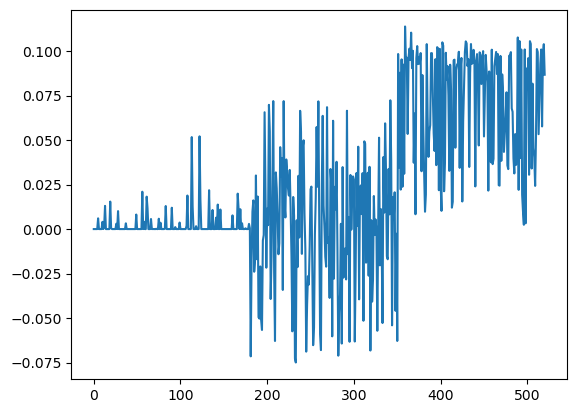

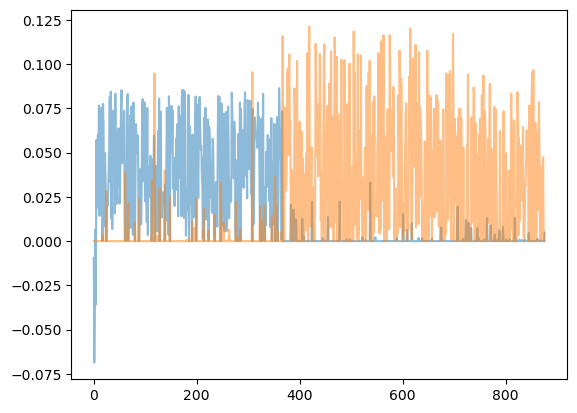

In [372]:
x, y = xy[:n], xy[n:]
s = b_transf - matrix_transf @ x

plt.plot(x, label='x')
plt.figure()
plt.plot(y, label='y', alpha=.5)
plt.plot(s, label='s', alpha=.5)
print(y.T @ s)

# MINI NEWTON_CG 

In [104]:
def line_search(xy, direction): # can be made much smarter, I understand enough dcsrch now
    current_loss = separated_loss(xy)
    for i in range(100):
        proposed = xy + direction * 0.5**i
        if separated_loss(proposed) < current_loss:
            break
    return proposed

FINAL LOSS: 5.013207684135979e-08
FINAL LOSS: 2.2336614022752972e-08
FINAL LOSS: 7.103871419007735e-09
FINAL LOSS: 2.2960431230258557e-09
FINAL LOSS: 4.934056476386888e-10
FINAL LOSS: 5.522459784737324e-10
FINAL LOSS: 1.2209644570790878e-09


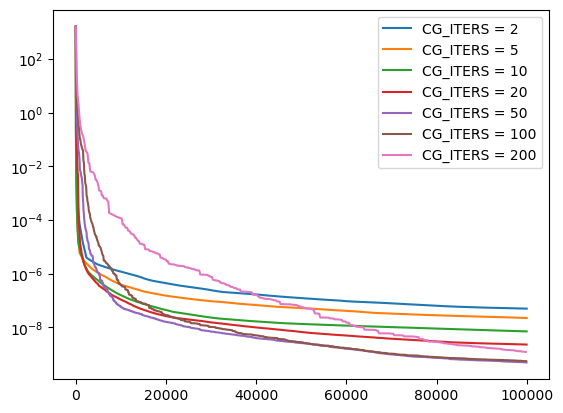

In [105]:
for CG_ITERS in [2,5,10,20,50,100,200]:
    
    np.random.seed(0)
    xy = np.random.randn(n+m)

    losses = []

    for i in range(100000//CG_ITERS):
        current_loss = separated_loss(xy)
        losses.append(current_loss)
        current_grad = separated_grad(xy)
        direction = sp.sparse.linalg.cg(
            separated_hessian(xy), -current_grad, atol=0., rtol=0., maxiter=CG_ITERS)[0]
        xy = line_search(xy, direction)

    plt.plot(np.arange(len(losses)) * CG_ITERS, losses, label=f'CG_ITERS = {CG_ITERS}')
    print('FINAL LOSS:', losses[-1])
plt.legend()
plt.yscale('log')
plt.show()
    # print('FINAL LOSS:', losses[-1])


# USING SOME TERMINATION RULE 

In [106]:
def run_with_term_rule(xy, MAXHESSIAN, cg_termination_rule):
    
    losses = [separated_loss(xy)]
    cg_used_iters = [0]
    USED_ITERS = 0
    
    for i in range(1000):
        if USED_ITERS > MAXHESSIAN:
            break
        def iter_counter(_):
            nonlocal USED_ITERS
            USED_ITERS += 1
        direction = sp.sparse.linalg.cg(
            separated_hessian(xy), -separated_grad(xy), **cg_termination_rule(xy),
            callback=iter_counter)[0]

        xy = line_search(xy, direction)
        
        losses.append(separated_loss(xy))
        cg_used_iters.append(int(USED_ITERS))
        if losses[-1] < 1e-25:
            break
        
        
    plt.plot(cg_used_iters, losses)
    print('FINAL LOSS:', losses[-1])
    plt.yscale('log')
    return xy


# FIX SEED 

In [107]:
SEED = 0
MAXITERS = 1000000

In [108]:
# np.random.seed(SEED)
# xy = np.random.randn(n+m)

# solution = run_with_term_rule(
#     xy, MAXHESSIAN=MAXITERS,
#     cg_termination_rule= lambda x: {'maxiter':200})

### Nocedal 

FINAL LOSS: 7.246752968237809e-26


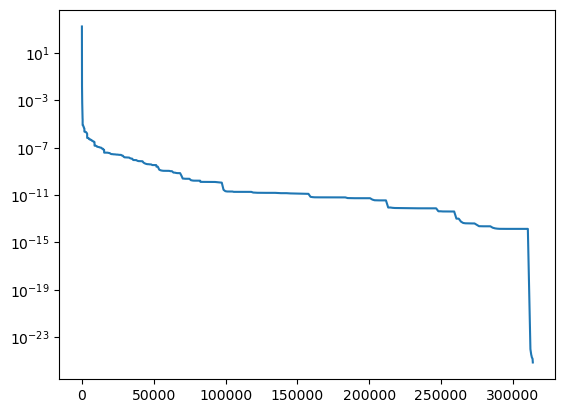

In [109]:
np.random.seed(SEED) # this was run with 1000 Ruiz iters
xy = np.random.randn(n+m)

solution = run_with_term_rule(
    xy, MAXHESSIAN=MAXITERS,
    cg_termination_rule=lambda xy: {'rtol':min(0.5, np.linalg.norm(separated_grad(xy)) ** 0.5)})

FINAL LOSS: 5.624313078551257e-30


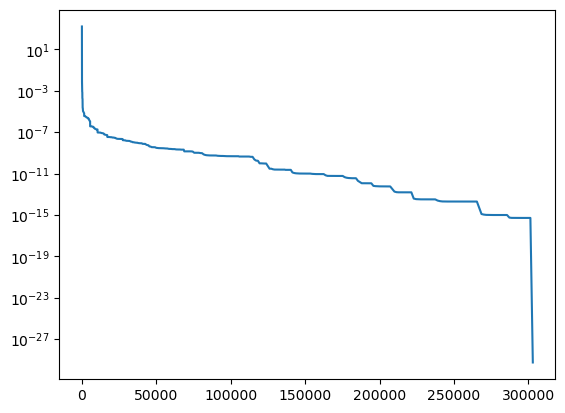

In [92]:
np.random.seed(SEED) # this was run with 100 Ruiz iters
xy = np.random.randn(n+m)

solution = run_with_term_rule(
    xy, MAXHESSIAN=MAXITERS,
    cg_termination_rule=lambda xy: {'rtol':min(0.5, np.linalg.norm(separated_grad(xy)) ** 0.5)})

### With different powers

FINAL LOSS: 9.964404118963978e-26


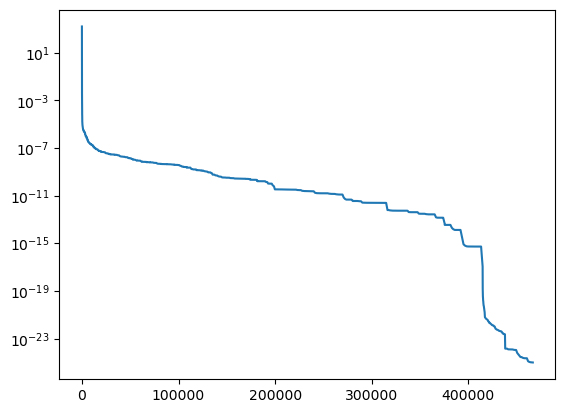

In [93]:
np.random.seed(SEED)
xy = np.random.randn(n+m)

solution = run_with_term_rule(
    xy, MAXHESSIAN=MAXITERS,
    cg_termination_rule=lambda xy: {'rtol':min(0.5, np.linalg.norm(separated_grad(xy)) ** 0.25)})

FINAL LOSS: 1.2870836166383337e-29


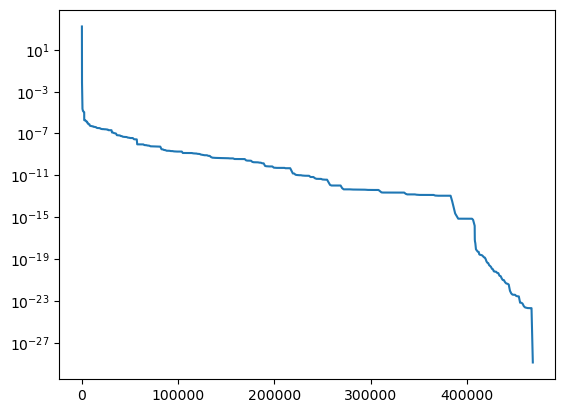

In [94]:
np.random.seed(SEED)
xy = np.random.randn(n+m)

solution = run_with_term_rule(
    xy, MAXHESSIAN=MAXITERS,
    cg_termination_rule=lambda xy: {'rtol':min(0.5, np.linalg.norm(separated_grad(xy)) ** 0.75)})

FINAL LOSS: 7.334390622227785e-26


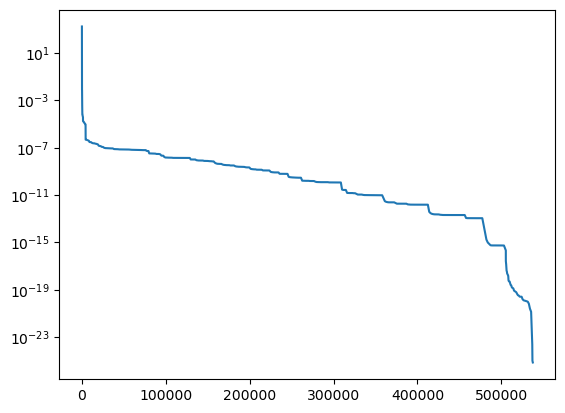

In [95]:
np.random.seed(SEED)
xy = np.random.randn(n+m)

solution = run_with_term_rule(
    xy, MAXHESSIAN=MAXITERS,
    cg_termination_rule=lambda xy: {'rtol':min(0.5, np.linalg.norm(separated_grad(xy)) ** 1)})

# FOR COMPARISON: LBFGS 

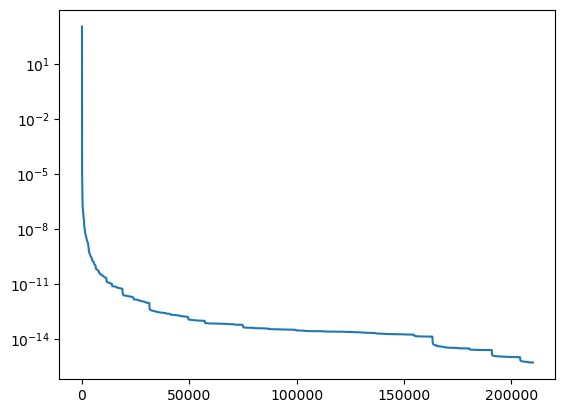

In [96]:
np.random.seed(SEED)
xy = np.random.randn(n+m)
def fun(xy):
    return separated_loss(xy), separated_grad(xy)

all_losses = []
def callback(xy):
    all_losses.append(separated_loss(xy))

sp.optimize.fmin_l_bfgs_b(
    fun,
    x0=xy,
    factr=0.,
    pgtol=0.,
    m=10,
    maxiter=MAXITERS*2,
    maxfun=np.inf,
    callback=callback,
)

plt.plot(np.arange(len(all_losses))/2., all_losses)
plt.yscale('log')

# FOR COMPARISON: DENSE SOLVE 

  0%|          | 0/1000 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

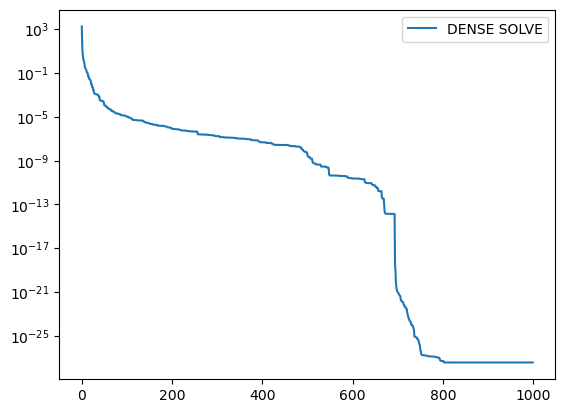

In [116]:
np.random.seed(0)
xy = np.random.randn(n+m)

losses = []

for i in range(1000):
    print(i)
    current_loss = separated_loss(xy)
    losses.append(current_loss)
    current_grad = separated_grad(xy)
    direction = np.linalg.lstsq(dense_hessian(xy), -current_grad, rcond=None)[0]
    xy = line_search(xy, direction)

plt.plot(np.arange(len(losses)), losses, label=f'DENSE SOLVE')
print('FINAL LOSS:', losses[-1])
plt.legend()
plt.yscale('log')
plt.show()
    # print('FINAL LOSS:', losses[-1])


In [717]:
800 * len(xy)/2

559200.0

# END 

In [20]:
raise Exception

Exception: 

In [ ]:
fixed_rule = lambda x: {'maxiter':200}
np.random.seed(0)
xy = np.random.randn(n+m)

solution = run_with_term_rule(xy, MAXHESSIAN=40000, cg_termination_rule=fixed_rule)

In [ ]:
xs = np.linspace(0,1)
losses = []
for step in xs:
    losses.append(separated_loss(xy + step * cg_solution))
    
plt.plot(xs, losses)
print(np.min(losses))

In [ ]:
plt.imshow(matrix_transf)
plt.colorbar()

In [ ]:
# system = sp.sparse.bmat([[None, matrix_transf.T], [matrix_transf, None]]).todense()

In [ ]:
plt.imshow(matrix_transf.T @ matrix_transf)
plt.colorbar()
plt.figure()
plt.plot(np.linalg.eigh(matrix_transf.T @ matrix_transf)[0])

In [ ]:
plt.imshow(matrix_transf @ matrix_transf.T)
plt.colorbar()
plt.figure()
plt.plot(np.linalg.eigh(matrix_transf @ matrix_transf.T)[0])